# ONS Charts

Created by Michael George (AKA Logiqx)

Website: https://logiqx.github.io/covid-stats/

## Imports

Standard python libraries plus determination of projdir, basic printable class, etc

In [1]:
import os

import csv
import numpy as np
import matplotlib.pyplot as plt

import common_core
import ons_core

## Load CSV Files

Load CSV data into cache

In [2]:
def loadCsvFile(areaType, areaName):
    '''Load CSV file into numpy array'''
    csvPath = os.path.join(common_core.projdir, "data", "ons-deaths", "csv", "weekly", "deaths", areaType)
    csvFn = os.path.join(csvPath, common_core.getSafeName(areaName) + ".csv")

    try:
        with open(csvFn, 'r') as f:
            reader = csv.reader(f, delimiter = ',')

            dtype = []
            converters = {}
            colNames = next(reader)

            for i in range(len(colNames)):
                colName = colNames[i]
                if colName == ons_core.WEEK_ENDED:
                    dtype.append((colName, "U10"))
                else:
                    dtype.append((colName, "u4"))
                    converters[i] = lambda s: int(s or 0)

            data = np.genfromtxt(f, dtype=dtype, converters=converters, delimiter=",")

    except:
        print(f"Failed to load CSV data for {areaName}")
        raise
        
    return data


def loadCsvFiles():
    '''Convert weekly registrations into weekly occurrences'''
    
    cache = {}
    
    for nationName in [common_core.ENGLAND_WALES, common_core.WALES]:
        cache[nationName] = loadCsvFile("nation", nationName)

    for regionName in common_core.regionNames:
        cache[regionName] = loadCsvFile("region", regionName)

    return cache

## Plot Data

Simple plots of ONS data

In [3]:
def plotData(cache, areaNames, maxWeeks = 52):
    '''Plot data for visual inspection'''
    
    # week_ended, week_number, total_registrations, covid_registrations, covid_occurrences
    # week_ended, week_number, total_deaths
    
    ewData = cache[common_core.ENGLAND_WALES]

    for areaName in areaNames:
        areaData = cache[areaName]

        figure = plt.figure(clear=True, figsize=(16, 6))  
        plt.title(areaName)
        plt.ylabel('Number of deaths')

        try:
            y_points = areaData[ons_core.TOTAL_OCCURRENCES][-maxWeeks:]
            x_points = np.arange(len(y_points))       
            plt.plot(x_points, y_points, label = "Total Occurrences", color='green')
        except:
            pass

        try:
            y_points = areaData[ons_core.TOTAL_REGISTRATIONS][-maxWeeks:]
            x_points = np.arange(len(y_points))       
            plt.plot(x_points, y_points, label = "Total Registrations", color='lightsteelblue')
        except:
            pass

        try:
            #y_points = ewData[ons_core.TOTAL_OCCURRENCES] * areaData[ons_core.TOTAL_REGISTRATIONS] / ewData[ons_core.TOTAL_REGISTRATIONS]
            x_points = np.arange(len(y_points))
            #plt.plot(x_points, y_points, label = "Estimated Occurrences", color='navy')
        except:
            pass

        try:
            y_points = areaData[ons_core.COVID_OCCURRENCES][-maxWeeks:]
            x_points = np.arange(len(y_points))       
            plt.plot(x_points, y_points, label = "COVID Occurrences", color='red')
        except:
            pass

        x_ticks = np.array(areaData[ons_core.WEEK_ENDED])[-maxWeeks:]
        plt.xticks(np.arange(0, len(x_ticks), step=1), x_ticks[::1], rotation=90)

        plt.yticks(np.arange(0, 24000, 1000))
        #figure.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        #plt.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        #plt.rc('ytick', labelsize=500) 
        
        plt.legend()

## Interactive Testing

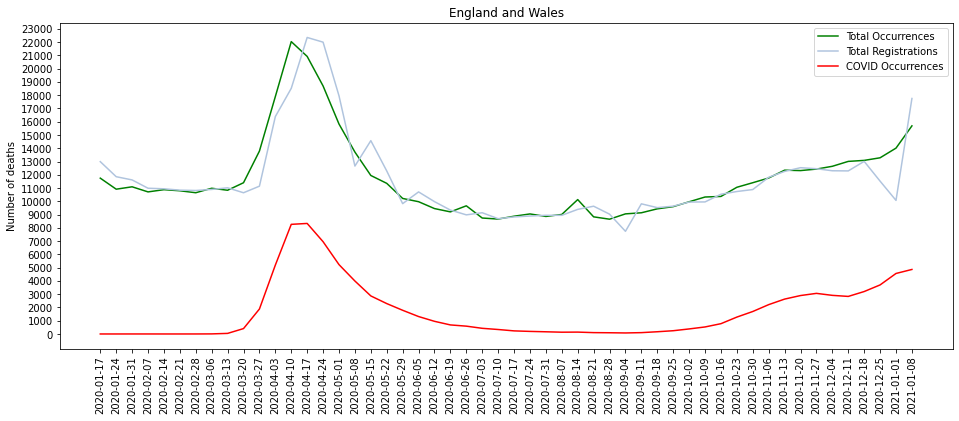

In [5]:
if __name__ == '__main__':
    # Cache can either be re-used or loaded from CSV files
    cache = loadCsvFiles()

    # Simple charts for review
    #areaNames = [common_core.ENGLAND_WALES, common_core.WALES] + common_core.regionNames
    areaNames = [common_core.ENGLAND_WALES]
    plotData(cache, areaNames)